In [72]:
# Basic Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import string

# Webscrapping Imports
from bs4 import BeautifulSoup       
import regex as re

# NLP Imports
from nltk.corpus import stopwords, wordnet
import nltk

# Modelling Imports
from joblib import Parallel, delayed
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction import text
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score

# Ignore warnings
import warnings
def ignore_warn(*args,**kwargs):
    pass
warnings.warn=ignore_warn

#Stylistic Choice:
plt.style.use('bmh')
sns.set_palette("RdBu_r")

In [2]:
#loading in datasets
onion = pd.read_csv('../data/theonion_clean.csv')
news = pd.read_csv('../data/news_cleaned.csv')

In [3]:
#quick look at the loaded datasets
onion

,created_utc,subreddit,title
0,1635090051,TheOnion,Smithsonian Acquires Arms Of Kermit The Frog P...
1,1634958726,TheOnion,Less Popular Friend Only Included In Suicide P...
2,1634940672,TheOnion,Crypto-Averse Man Would Prefer Investing In Tr...
3,1634910709,TheOnion,God Loses Pouch Filled With Crystals That Give...
4,1634872463,TheOnion,Retired NFL Player Touts Sports Betting App As...
...,...,...,...
2013,1580708304,TheOnion,"The Onion is made a podcast called ""The Topica..."
2014,1580691176,TheOnion,"‘I’m Just Here For The Commercials,’ Jokes Man..."
2015,1580669936,TheOnion,My god how much Budget did they have for this?
2016,1580662117,TheOnion,Snacks Distract Lawmakers From Horrors of War


In [4]:
#quick look at the loaded datasets
news

,created_utc,subreddit,title
0,1635118883,news,Supporters of unvaccinated NBA star Kyrie Irvi...
1,1635118006,news,Body of missing 26-year-old Texas man found in...
2,1635116237,news,Two SF Prosecutors Quit &amp; Join Effort to O...
3,1635115094,news,"James Michael Tyler, who played Gunther in 'Fr..."
4,1635114451,news,Plane from NY to LA makes emergency landing in...
...,...,...,...
2006,1633613759,news,Man laundered $1M from romance scheme that tar...
2007,1633613721,news,Florida lifts 30-year ban on catching goliath ...
2008,1633613692,news,"After Keys deputies talk to injured woman, boy..."
2009,1633613650,news,Dutch watchdog finds Apple app store payment r...


# Preprocessing

To map data from "The Onion" as 0 and data from "News" as 1.

In [5]:
onion['label'] = 0
onion.shape

(2018, 4)

In [6]:
news['label'] = 1
news.shape

(2011, 4)

In [7]:
#as mentioned previously in the EDA, some non-english characters were found, since we are only interested in english words
#we will only be looking at ascii characters
onion['title'] = onion['title'].str.encode("ascii", "ignore")
news['title'] = news['title'].str.encode("ascii", "ignore")

In [113]:
#combining both datasets
df = pd.concat([onion, news], axis=0)

In [114]:
#quick look at the loaded datasets
df

,created_utc,subreddit,title,label
0,1635090051,TheOnion,b'Smithsonian Acquires Arms Of Kermit The Frog...,0
1,1634958726,TheOnion,b'Less Popular Friend Only Included In Suicide...,0
2,1634940672,TheOnion,b'Crypto-Averse Man Would Prefer Investing In ...,0
3,1634910709,TheOnion,b'God Loses Pouch Filled With Crystals That Gi...,0
4,1634872463,TheOnion,b'Retired NFL Player Touts Sports Betting App ...,0
...,...,...,...,...
2006,1633613759,news,b'Man laundered $1M from romance scheme that t...,1
2007,1633613721,news,b'Florida lifts 30-year ban on catching goliat...,1
2008,1633613692,news,"b'After Keys deputies talk to injured woman, b...",1
2009,1633613650,news,b'Dutch watchdog finds Apple app store payment...,1


In [115]:
#index reset for merged dataset as a quick look shows that the index was unchanged from before 
df.reset_index(inplace=True)

#drop created_utc and old index as these will not be useful
df.drop(["index", "created_utc"], axis=1, inplace=True)

In [116]:
#check if index was change successfully
df

,subreddit,title,label
0,TheOnion,b'Smithsonian Acquires Arms Of Kermit The Frog...,0
1,TheOnion,b'Less Popular Friend Only Included In Suicide...,0
2,TheOnion,b'Crypto-Averse Man Would Prefer Investing In ...,0
3,TheOnion,b'God Loses Pouch Filled With Crystals That Gi...,0
4,TheOnion,b'Retired NFL Player Touts Sports Betting App ...,0
...,...,...,...
4024,news,b'Man laundered $1M from romance scheme that t...,1
4025,news,b'Florida lifts 30-year ban on catching goliat...,1
4026,news,"b'After Keys deputies talk to injured woman, b...",1
4027,news,b'Dutch watchdog finds Apple app store payment...,1


In [12]:
#defining X and y for train-test split
X = df['title']
y = df['label']

In [13]:
#spliting data into train and test sets for modeling
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    stratify=y,
                                                    random_state=42)

In [14]:
#quick check for data split
X_train

637     b'Conservative Christian Deeply Offended At Ra...
2202    b'Man charged with murder for fatal shooting o...
3071    b'David Amess MP dies after being stabbed at c...
948     b'A shocking new study that asked teen boys ab...
2078    b'Interview| Social media has become a behavio...
                              ...                        
2041    b'3.6 magnitude earthquake rattles metro Los A...
1890    b'CDC Warns Against Health Risks Of Flavored G...
1726    b'Trump Admits 18 New States To Increase Compe...
734     b'Ted Cruz Deeply Disturbed By Part Of Capitol...
2159    b'Swedens royals follow Dutch and confirm same...
Name: title, Length: 2820, dtype: object

In [15]:
#quick check for data split
y_train

637     0
2202    1
3071    1
948     0
2078    1
       ..
2041    1
1890    0
1726    0
734     0
2159    1
Name: label, Length: 2820, dtype: int64

As accuracy is of utmost importance since we're dealing with detecting fake news from only the titles, lemmatizing is chosen over stemming to process words.

In [16]:
#creating a function to remove punctuation and change letters to lowercase, then lemmatize the non-stopwords

wn = nltk.WordNetLemmatizer()

def clean_text(text):
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    # \W matches any non-word character (equivalent to [^a-zA-Z0-9_]). This does not include spaces i.e. \s
    # Add a + just in case there are 2 or more spaces between certain words
    tokens = re.split('\W+', text)
    
    # apply lemmatizing and stopwords exclusion within the same step
    text = [wn.lemmatize(word) for word in tokens if word not in stopwords.words('english')]
    return text

In [17]:
#creating an instance of Count Vectorizer and pass in the clean_text function as the analyzer parameter
count_vect = CountVectorizer(analyzer=clean_text)

#storing the count vectorized version of the data
X_counts_train = count_vect.fit_transform(X_train)
X_counts_test = count_vect.transform(X_test)

#checking shape of data
print(X_counts_train.shape)
print(X_counts_test.shape)

(2820, 7692)
(1209, 7692)


In [18]:
#creating an instance of tf-idf Vectorizer to pass the clean_text function as the analyzer parameter
tvec = TfidfVectorizer(analyzer=clean_text)

#storing the tfidf vectorized version of the data
X_tfidf_train = tvec.fit_transform(X_train)
X_tfidf_test = tvec.transform(X_test)

#checking shape of data
print(X_tfidf_train.shape)
print(X_tfidf_test.shape)

(2820, 7692)
(1209, 7692)


# Modeling

## Logistic Regression

In [ ]:
lr = LogisticRegression(solver = 'lbfgs')

<b>Count Vectorizer</b>

In [19]:
#fit model to training data
lr.fit(X_counts_train, y_train)

#evaluate model on training data
lr.score(X_counts_train, y_train)

0.9929078014184397

In [20]:
#evaluate model on test data
lr.score(X_counts_test, y_test)

0.8287841191066998

In [21]:
#checking model on CV score for train data
cross_val_score(lr, X_counts_train, y_train, cv=10).mean()

0.8241134751773049

In [122]:
#checking model on CV score for test data
cross_val_score(lr, X_counts_test, y_test, cv=10).mean()

0.7882162534435262

<b>tf-idf Vectorizer</b>

In [25]:
#fit model to training data
lr.fit(X_tfidf_train, y_train)

#evaluate model on train data
lr.score(X_tfidf_train, y_train)

0.9641843971631205

In [26]:
#evaluate model on test data
lr.score(X_tfidf_test, y_test)

0.8387096774193549

In [51]:
#checking model on CV score for train data
cross_val_score(lr, X_tfidf_train, y_train, cv=10).mean()

0.824468085106383

In [28]:
#checking model on CV score for test data
cross_val_score(lr, X_tfidf_test, y_test, cv=10).mean()

0.8039462809917355

## Naive Bayes

In [32]:
from sklearn.naive_bayes import MultinomialNB

#defining parameters for naive bayes
nb = MultinomialNB(class_prior=[0.4,0.6])

**Count Vectorizer**

In [33]:
#fitting model to count vect train data
modelcv = nb.fit(X_counts_train, y_train)

In [34]:
#evaluate model on train data
nb.score(X_counts_train, y_train)

0.9684397163120567

In [35]:
#evaluate model on test data
nb.score(X_counts_test,y_test)

0.8287841191066998

In [118]:
#checking model on CV score for train data
cross_val_score(nb, X_counts_train, y_train, cv=10).mean()

0.827304964539007

In [119]:
#checking model on CV score for test data
cross_val_score(nb, X_counts_test, y_test, cv=10).mean()

0.7973278236914602

**tf-idf Vectorizer**

In [36]:
#fitting model to tfidf vect train data
modeltfidf = nb.fit(X_tfidf_train, y_train)

In [37]:
#evaluate model on train data
nb.score(X_tfidf_train, y_train)

0.9372340425531915

In [38]:
#evaluate model on test data
nb.score(X_tfidf_test,y_test)

0.7932175351530191

In [120]:
#checking model on CV score for train data
cross_val_score(nb, X_tfidf_train, y_train, cv=10).mean()

0.7563829787234042

In [121]:
#checking model on CV score for test data
cross_val_score(nb, X_tfidf_test, y_test, cv=10).mean()

0.7245316804407713

In [123]:
#summarizing model results

train_score = [0.993, 0.964, 0.968, 0.937]
test_score = [0.829, 0.839, 0.829, 0.793]
train_cv_score = [0.824, 0.824, 0.827, 0.756]
test_cv_score = [0.788, 0.804, 0.797, 0.725]
Evaluation = pd.DataFrame([train_score, test_score, train_cv_score, test_cv_score],
                          columns=['CVec LR', 'TVec LR', 'CVec NB', 'TVec NB'], 
                          index=['Train Score', 'Test Score', 'CV Train Score', 'CV Test Score'])
Evaluation

,CVec LR,TVec LR,CVec NB,TVec NB
Train Score,0.993,0.964,0.968,0.937
Test Score,0.829,0.839,0.829,0.793
CV Train Score,0.824,0.824,0.827,0.756
CV Test Score,0.788,0.804,0.797,0.725


All 4 models produced fairly similar decent results, with only tf-idf naive bayes falling slightly below 0.8 for test score. As tf-idf logistic regression has the highest test and CV test scores, we will attempt to optimise the model for better results.

# GridSearch

In [40]:
#loading in pipe
pipe = Pipeline([
    ('tvec', TfidfVectorizer(analyzer=clean_text)),
    ('lr', LogisticRegression())])

In [41]:
#checking cross val score for pipe default
cross_val_score(pipe, X_train, y_train, cv=10).mean()

0.8262411347517731

In [42]:
#defining pipe parameters
pipe_params = {
    'tvec__max_features': [7500,10000, None],
    'tvec__min_df' : [1,2],
    'tvec__max_df': [0.85, 0.9, 0.95, 1],
    'tvec__ngram_range': [(1,1),(1,2)]}

In [46]:
#defining gridsearch parameters. cv=3 was chosen as higher values took too long to run 
gs = GridSearchCV(pipe, 
                  pipe_params, 
                  cv=3, verbose=2, n_jobs=1) 

In [47]:
#fitting gridsearch to the data
gs.fit(X_train, y_train)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV] END tvec__max_df=0.85, tvec__max_features=7500, tvec__min_df=1, tvec__ngram_range=(1, 1); total time=   8.6s
[CV] END tvec__max_df=0.85, tvec__max_features=7500, tvec__min_df=1, tvec__ngram_range=(1, 1); total time=   8.6s
[CV] END tvec__max_df=0.85, tvec__max_features=7500, tvec__min_df=1, tvec__ngram_range=(1, 1); total time=   8.7s
[CV] END tvec__max_df=0.85, tvec__max_features=7500, tvec__min_df=1, tvec__ngram_range=(1, 2); total time=   8.7s
[CV] END tvec__max_df=0.85, tvec__max_features=7500, tvec__min_df=1, tvec__ngram_range=(1, 2); total time=   8.6s
[CV] END tvec__max_df=0.85, tvec__max_features=7500, tvec__min_df=1, tvec__ngram_range=(1, 2); total time=   8.6s
[CV] END tvec__max_df=0.85, tvec__max_features=7500, tvec__min_df=2, tvec__ngram_range=(1, 1); total time=   8.5s
[CV] END tvec__max_df=0.85, tvec__max_features=7500, tvec__min_df=2, tvec__ngram_range=(1, 1); total time=   8.4s
[CV] END tvec__max_df=0.85

[CV] END tvec__max_df=0.95, tvec__max_features=7500, tvec__min_df=1, tvec__ngram_range=(1, 1); total time=   8.5s
[CV] END tvec__max_df=0.95, tvec__max_features=7500, tvec__min_df=1, tvec__ngram_range=(1, 1); total time=   8.4s
[CV] END tvec__max_df=0.95, tvec__max_features=7500, tvec__min_df=1, tvec__ngram_range=(1, 1); total time=   8.7s
[CV] END tvec__max_df=0.95, tvec__max_features=7500, tvec__min_df=1, tvec__ngram_range=(1, 2); total time=   8.5s
[CV] END tvec__max_df=0.95, tvec__max_features=7500, tvec__min_df=1, tvec__ngram_range=(1, 2); total time=   8.7s
[CV] END tvec__max_df=0.95, tvec__max_features=7500, tvec__min_df=1, tvec__ngram_range=(1, 2); total time=   8.7s
[CV] END tvec__max_df=0.95, tvec__max_features=7500, tvec__min_df=2, tvec__ngram_range=(1, 1); total time=   8.5s
[CV] END tvec__max_df=0.95, tvec__max_features=7500, tvec__min_df=2, tvec__ngram_range=(1, 1); total time=   8.5s
[CV] END tvec__max_df=0.95, tvec__max_features=7500, tvec__min_df=2, tvec__ngram_range=(

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tvec',
                                        TfidfVectorizer(analyzer=<function clean_text at 0x00000131D7102CA0>)),
                                       ('lr', LogisticRegression())]),
             n_jobs=1,
             param_grid={'tvec__max_df': [0.85, 0.9, 0.95, 1],
                         'tvec__max_features': [7500, 10000, None],
                         'tvec__min_df': [1, 2],
                         'tvec__ngram_range': [(1, 1), (1, 2)]},
             verbose=2)

In [53]:
#quick look at gridsearch CV theorized best parameters
gs.best_params_

{'tvec__max_df': 0.85,
 'tvec__max_features': 7500,
 'tvec__min_df': 1,
 'tvec__ngram_range': (1, 1)}

In [54]:
#applying gridsearch results
gs_model_lr = gs.best_estimator_
gs_model_lr

Pipeline(steps=[('tvec',
                 TfidfVectorizer(analyzer=<function clean_text at 0x00000131D7102CA0>,
                                 max_df=0.85, max_features=7500)),
                ('lr', LogisticRegression())])

In [131]:
#gridsearch results train score
gs_model_lr.score(X_train, y_train)

0.9638297872340426

In [132]:
#gridsearch results test score
gs_model_lr.score(X_test, y_test)

0.837055417700579

In [56]:
#gridsearch results cross val score
cross_val_score(gs_model_lr, X_train, y_train, cv=10).mean()

0.8262411347517731

GridSearch optimising only increased the CV score but did not seem to help with train or test scores. Will stick with default tf-idf Logistic Regression for further evaluation.

# ROC curve

In [63]:
#test predictions based on tfidf logistic regression
predicted_test = lr.predict(X_tfidf_test)

In [70]:
#probability that the test is correct
y_score = lr.predict_proba(X_tfidf_test)[:,1]

In [82]:
#quick look at how close the probability is to the true value
pred_df_lr = pd.DataFrame({'True Value': y_test,
                        'Pred Prob':y_score})

pred_df_lr.head()

,True Value,Pred Prob
1764,0,0.334890
2271,1,0.748355
1535,0,0.291102
3264,1,0.477382
656,0,0.467276


In [83]:
#check for roc score
print('roc_auc_score for Logistic Regression: ', roc_auc_score(y_test, y_score))

roc_auc_score for Logistic Regression:  0.9136057884395405


In [73]:
#defining threshold for roc curve
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_score)

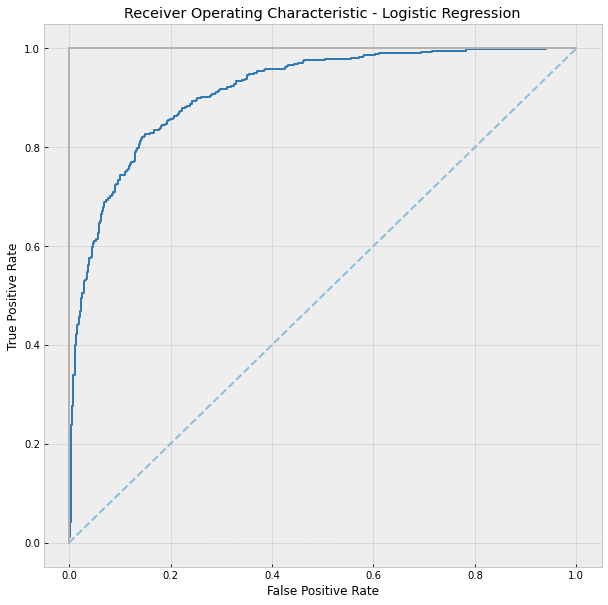

In [140]:
#plotting of roc curve
plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - Logistic Regression')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

ROC curve looks fairly good, with a curve score of 0.914.

# Logistic Regression Coefficients

In [108]:
#creating an index with the vectorized words
index = tvec.get_feature_names()

#making df of features w/coeffs
lr_coef_df = pd.DataFrame(lr.coef_[0],
                         columns=["co-eff"],
                         index=index)
#sorting for highest coeff
lr_coef_df = lr_coef_df.sort_values("co-eff", ascending=False)
lr_coef_df.head()

,co-eff
us,3.433609
covid19,2.668693
china,2.591363
covid,2.164708
killed,2.010831


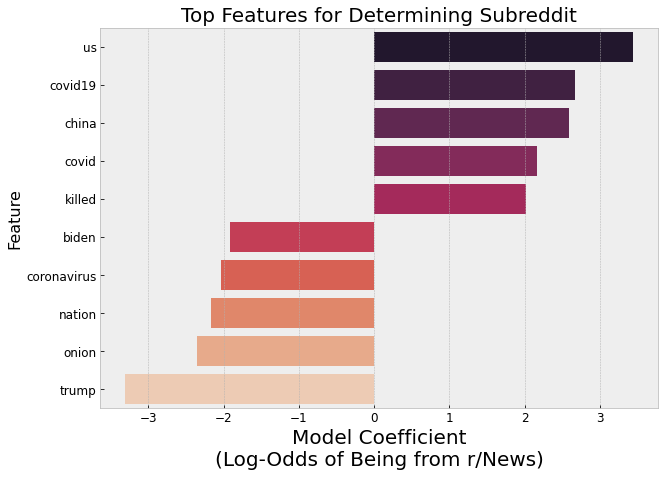

In [129]:
#isolating top and bottom coefs
lr_coef_odds = pd.concat(objs=[lr_coef_df.head(), lr_coef_df.tail()])

#plotting most significant coefs
plt.figure(figsize=(10, 7))
sns.barplot(data=lr_coef_odds,
            x="co-eff",
            y=lr_coef_odds.index,
            palette="rocket")
plt.title("Top Features for Determining Subreddit", size=20)
plt.yticks(size=12)
plt.xticks(size=12)
plt.ylabel("Feature", size=16)
plt.xlabel("Model Coefficient\n(Log-Odds of Being from r/News)", size=20);

Top features for determining r/News are US, Covid-19, Covid, China and killed. Whereas onion, nation, coronavirus and US presidents (Trump and Biden) were significant predictors of fake news and satire from r/TheOnion.

In [128]:
#a quick look at the odds in normal form
lr_coef_odds["odds"] = lr_coef_odds.apply(lambda x: np.exp(x))
lr_coef_odds

,co-eff,odds
us,3.433609,30.988267
covid19,2.668693,14.421113
china,2.591363,13.347954
covid,2.164708,8.712057
killed,2.010831,7.469522
biden,-1.911991,0.147786
coronavirus,-2.041225,0.129869
nation,-2.171659,0.113988
onion,-2.347835,0.095576
trump,-3.303935,0.036738


In [136]:
#generating confusion matrix to check results
cm_lr = confusion_matrix(y_test, predicted_test)

tn, fp, fn, tp = cm_lr.ravel()

print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

True Negatives: 519
False Positives: 87
False Negatives: 108
True Positives: 495


In [137]:
#confusion matrix in table form
cm_df = pd.DataFrame(cm_lr, columns=['Predicted News', 'Predicted Fake'], index=['Actual News', 'Actual Fake'])
cm_df

,Predicted News,Predicted Fake
Actual News,519,87
Actual Fake,108,495


In [104]:
#function to provide accuracy, sensitivity and specificity of model
def confusion(cm):
    tn, fp, fn, tp = cm.ravel()
    spec = round(tn / (tn + fp),4)
    sens = round(tp / (tp + fn),4)
    acc = round((tp+tn) / (tp+fn+tn+fp),4)
    return spec,sens,acc

In [105]:
#quick check if function works as intended
cm_lr_array = confusion(cm_lr)
print(cm_lr_array)

(0.8564, 0.8209, 0.8387)


## Model Summary

In [139]:
#summarizing results in a final frame
results = [0.8564, 0.8209, 0.8387, 0.914, 0.964, 0.839]
cm_df_all = pd.DataFrame(results).T
cm_df_all.columns=['Specificity','Sensitivity','Accuracy', 'ROC Score', 'Train Score', 'Test Score']
cm_df_all.index=['tf-idf Logistic Regression Model']

cm_df_all

,Specificity,Sensitivity,Accuracy,ROC Score,Train Score,Test Score
tf-idf Logistic Regression Model,0.8564,0.8209,0.8387,0.914,0.964,0.839


# Conclusion

The goal of the model was to predict whether the title could indicate whether it was possible to tell between real news and satire. Despite the data being slightly overfitted with a higher train score than test score, given that the relatively high ROC score of 0.914 and Test score of 0.838 was attained, we can conclude that the model is quite successful in predicting whether a post was real or satire based on the text in its headline.

Interestingly, the words Covid, Covid19, US and China were found to be better predictors of real news, whereas satire tends to use the term Coronavirus (instead of just Covid) and focused a lot more on the former and current US presidents, Trump and Biden. This could partly be due to wanting to include 'virus' in the naming for fearmongering purposes.

## Limitations

As noted in the EDA, posts from r/TheOnion spanned a much greater length of time as compared to r/News. As such, the model trained is going to be skewed towards a much short length of time from r/News, whereas r/TheOnion posts would more widely spread out. This could have partly inhibited of the success of the model as The Onion covered the US presidential elections, a hot topic in the US whilst News is already some time away from it.

## Future Outlook

As mentioned in the limitations, the data scrapped from both subreddits were from different time frames, to circumvent this, we can scrap more data from r/News subreddit and randomly pick a sample of posts from each month. This will allow us to better map titles to their respective post dates, and prevent a skew in data towards missing events.

Another possible aspect would be to perform sentiment analysis on the words found in both subreddits. From the EDA, it seemed like words from r/News are slightly more sombre with words like death, shooting and killed being visibly seen from the word cloud, indicating that sentiment might be more negative on r/News and it could be a possible predictor as well.